In [1]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import sys, os; sys.path.insert(0, '../')
import Baryonification as bfn
import pyccl as ccl
import h5py, io, copy, gc, time
from numba import njit

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175 - 0.049 , Omega_b = 0.049, h=0.6711, sigma8=0.82, n_s=0.9649,
                      matter_power_spectrum='linear')
h = cosmo.cosmo.params.h

#Config params. Let's use the default values as deemed in Schneider19
bpar = dict(theta_ej = 4, theta_co = 0.1, 
            M_c = 1e14/h,
            mu_beta = 0.4,
            eta = 0.3, eta_delta = 0.3, 
            tau = -np.inf, tau_delta = 0, #They don't use a tau so we zero ours (-inf also needed to cancel one term)
            A = 0.09/2, #Factor 2 Needed so that the high-mass behaviors of our model is same as theirs
            M1 = 2.5e11/h,
            epsilon_h = 0.015, a = 0.3, n = 2, epsilon = 4, p = 0.3, q = 0.707, 
            gamma = 2, delta = 7, proj_cutoff = 205/h/2)

In [2]:
#Convenience function for histogram things quickly

@njit
def numba_histogram3d(points, bins, min_vals, max_vals):
    counts = np.zeros((bins, bins, bins), dtype=np.int64)
    bin_width = (max_vals - min_vals) / bins

    for i in range(points.shape[0]):
        ix = int((points[i, 0] - min_vals) / bin_width)
        iy = int((points[i, 1] - min_vals) / bin_width)
        iz = int((points[i, 2] - min_vals) / bin_width)
        
        counts[ix, iy, iz] += 1

    return counts

In [3]:
#Load figure data
Tab = './S19_Fig2_Scrapped.csv'
P   = open(Tab).readline().split(',')[::2]
N   = []
for p in P: N += [f'{p}_X', f'{p}_Y']
S19 = pd.read_csv(Tab, skiprows = 2, names = N)

# First download TNG data

In [4]:
import requests #or do "pip install requests"

#You need a TNG API key. Sign-up for an account here: https://www.tng-project.org/data/
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key" : open('../../TNG_API_KEY.txt', 'r').readline().strip()}

In [5]:
def get(path, params=None):
    
    r = requests.get(path, params=params, headers=headers, stream=True)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json': return r.json()
    
    return r

In [6]:
####################################
#STEP 1: Get all the particle data
####################################
p = f"{os.environ['SCRATCH']}/TNG300-3-Dark-particles.npy"
if os.path.isfile(p):    
    print("LOADING EXISTING FILE FOR DM PARTICLES")
    particles = np.load(p)

else:
    particles    = []
    sim_metadata = get("http://www.tng-project.org/api/TNG300-3-Dark/")
    for i in range(sim_metadata['num_files_snapshot']):

        file_url       = base_url + "files/snapshot-99." + str(i) + ".hdf5"
        saved_filename = get(file_url, {'dm':'Coordinates'})

        with h5py.File(io.BytesIO(saved_filename.content), 'r') as f:
            particles.append(
                f['PartType1']['Coordinates'][:] * 1e-3/h #from kpc/h to Mpc
            )

        print("DONE WITH CHUNK", i)
    
    particles = np.concatenate(particles, axis = 0, dtype = np.float32)
    np.save(p, particles)
    
####################################
#STEP 1: Get all the Halo mass
####################################
p = f"{os.environ['SCRATCH']}/TNG300-3-Dark-HaloMass.npy"
if os.path.isfile(p):
    print("LOADING EXISTING FILE FOR HALO MASS")
    HaloMass = np.load(p)
else:
    saved_filename = get(base_url + "files/groupcat-99/", {'Group':'Group_M_Crit200'})
    with h5py.File(io.BytesIO(saved_filename.content), 'r') as f:
        HaloMass = f['Group']['Group_M_Crit200'][:] * 1e10/h #from 1e10/h Msun --> Msun

p = f"{os.environ['SCRATCH']}/TNG300-3-Dark-HaloPos.npy"
if os.path.isfile(p):
    print("LOADING EXISTING FILE FOR HALO POS")
    HaloPos = np.load(p)
else:
    saved_filename = get(base_url + "files/groupcat-99/", {'Group':'GroupCM'})
    with h5py.File(io.BytesIO(saved_filename.content), 'r') as f:
        HaloPos = f['Group']['GroupCM'][:] * 1e-3/h #from kpc/h --> Mpc

LOADING EXISTING FILE FOR DM PARTICLES
LOADING EXISTING FILE FOR HALO MASS
LOADING EXISTING FILE FOR HALO POS


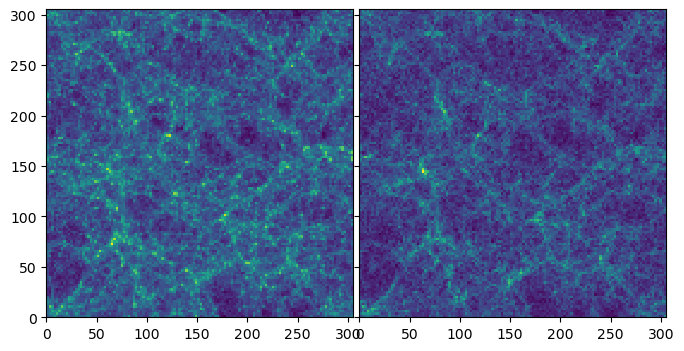

In [7]:
#Just a quick plot to show the structure is totally consistent amongst the two
bins = np.linspace(0, 205/h, 128 + 1)

import matplotlib as mpl
fig, ax = plt.subplots(1, 2, figsize = (8, 4), sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.02)

ax[0].hist2d(particles[:, 0], particles[:, 1], bins = bins, norm = mpl.colors.LogNorm())
ax[1].hist2d(HaloPos[:, 0], HaloPos[:, 1], bins = bins)

plt.show()

# Setup the runners

In [8]:
#Reverting back from Giri+Schneider Beta(M) model to the Schneider+19 model
class Gas_S19(bfn.Gas):
    
    def _get_gas_params(self, M, z):
        
        beta, theta_ej, theta_co, delta, gamma = super()._get_gas_params(M, z)
        
        beta = 3 - np.power(self.M_c/M, self.mu_beta)[:, None]
        
        return beta, theta_ej, theta_co, delta, gamma

In [9]:
cdict   = {'Omega_m' : 0.3175, 'sigma8' : 0.834, 'h' : 0.6711, 'n_s' : 0.9649, 'w0' : -1, 'Omega_b' : 0.049}

Mask  = HaloMass > np.power(10, 12.8)
HCat  = bfn.HaloNDCatalog(x = HaloPos[:, 0][Mask],
                          y = HaloPos[:, 1][Mask], 
                          z = HaloPos[:, 2][Mask], 
                          M = HaloMass[Mask], redshift = 0, cosmo = cdict)

Snap  = bfn.ParticleSnapshot(x = particles[:, 0], 
                             y = particles[:, 1],
                             z = particles[:, 2], 
                             L = 205/h,
                             redshift = 0, cosmo = cdict)

In [10]:
#Model is "None" just so we setup the KDTree first. We will populate the model var later, as we swap through params
Runner = bfn.Runners.BaryonifySnapshot(HCat, Snap, epsilon_max = 5, model = None, 
                                       KDTree_kwargs = {'leafsize' : 1e3, 'balanced_tree' : False, 'compact_nodes' : False})

In [11]:
#Create the particle set for the snapshot already
Part_D = np.array([Snap.cat[x][:] for x in 'xyz']).T

#Setup the other params as well, mainly the grids, since we only use it once
Ngrd   = 256
Nk     = 180
Lbox   = Snap.L
kbins  = np.linspace(2*np.pi/Lbox, 2*np.pi/Lbox * Ngrd/2, Nk + 1)
klin   = np.fft.fftfreq(Ngrd, 1 / (2*np.pi/(Lbox)) / Ngrd)
k      = np.sqrt(klin[:, None, None]**2 + klin[None, None, :]**2 + klin[None, :, None]**2).flatten()
kinds  = np.floor((k - kbins[0]) / (kbins[1] - kbins[0])).astype(int)
kmsk   = (kinds >= 0) & (kinds < Nk)
k_c    = np.bincount(kinds[kmsk], minlength = Nk)
k_cen  = np.bincount(kinds[kmsk], minlength = Nk, weights = k[kmsk]) / k_c

In [12]:
del particles, k; gc.collect();

# Now do M_c

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


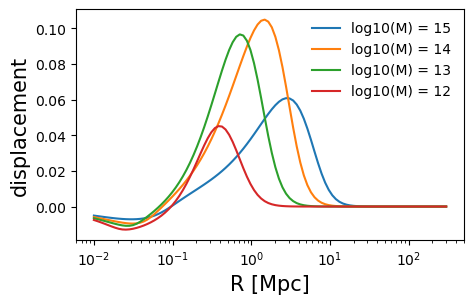

Baryonifying matter: 100%|██████████| 7088/7088 [01:40<00:00, 70.61it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 37252272388615.7
08:44:59
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 37252272388615.7
08:45:56


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


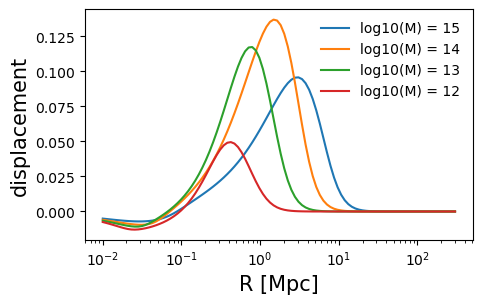

Baryonifying matter: 100%|██████████| 7088/7088 [01:41<00:00, 69.70it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 74504544777231.4
08:49:11
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 74504544777231.4
08:49:38


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


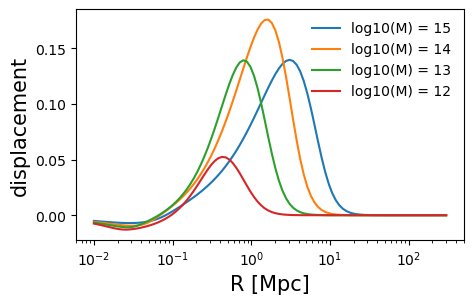

Baryonifying matter: 100%|██████████| 7088/7088 [01:42<00:00, 68.86it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 149009089554462.8
08:52:53
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 149009089554462.8
08:53:19


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


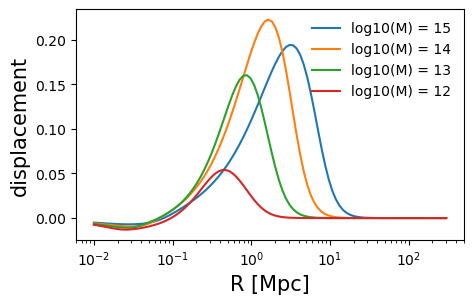

Baryonifying matter: 100%|██████████| 7088/7088 [01:42<00:00, 69.08it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 298018179108925.6
08:56:36
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 298018179108925.6
08:57:03


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


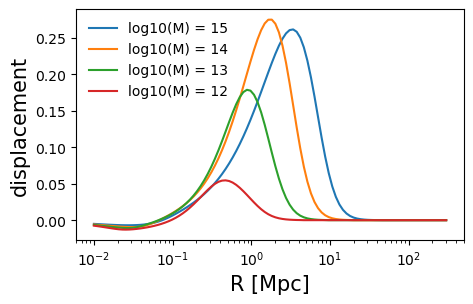

Baryonifying matter: 100%|██████████| 7088/7088 [01:42<00:00, 69.48it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 596036358217851.2
09:00:16
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 596036358217851.2
09:00:42


In [13]:
RES_M_c = {'DM' : {}}

for param in [2.5e13/h, 5e13/h, 1e14/h, 2e14/h, 4e14/h]:
    
    RES_M_c[param] = {}
    
    tmp = copy.deepcopy(bpar)
    tmp['M_c'] = param
    DMO = bfn.DarkMatterOnly(**tmp)
    DMB = bfn.DarkMatterBaryon(**tmp, gas = Gas_S19(**tmp))

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfn.Profiles.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = 20)
    Displacement.setup_interpolator(z_min = 0, z_max = 0.01, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)
    
    #Plot to show
    R = np.geomspace(0.01, 300, 100)
    plt.figure(figsize = (5,3)); plt.xscale('log')
    for M in [1e15, 1e14, 1e13, 1e12]: plt.plot(R, Displacement.displacement(R, M, 1), label = 'log10(M) = %d' % np.log10(M))
    plt.ylabel('displacement', size = 15); plt.xlabel('R [Mpc]', size = 15); plt.legend(frameon = False)
    plt.show()
    
    #Swap in the new model into the Snapshot runner
    #And run the map!
    Runner.model    = Displacement
    Baryonified_Map = Runner.process()
    
    #Baryonified particle set
    Part_B = np.array([Baryonified_Map[x][:] for x in 'xyz']).T
    del Baryonified_Map; gc.collect()

    for factor in [1, 8]:

        Lbox = Snap.L / factor
        bins = np.linspace(0, Lbox, Ngrd + 1)
        
        MapB = numba_histogram3d(Part_B % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
        FFTB = np.fft.fftn(MapB); del MapB; gc.collect()
        FFTB = (np.conjugate(FFTB) * FFTB).real.flatten()
        PkB  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTB[kmsk]) / k_c; del FFTB; gc.collect()
        
        if f'Factor{factor}' not in RES_M_c['DM'].keys():
            MapD = numba_histogram3d(Part_D % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
            FFTD = np.fft.fftn(MapD);  del MapD; gc.collect()
            FFTD = (np.conjugate(FFTD) * FFTD).real.flatten()
            PkD  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTD[kmsk]) / k_c; del FFTD; gc.collect()
            RES_M_c['DM'][f'Factor{factor}'] = PkD
            
        else:
            PkD = RES_M_c['DM'][f'Factor{factor}']

        
        RES_M_c[param][f'Factor{factor}'] = {'k' : k_cen * factor, 'S' : PkB/PkD}
        
        print(f"FINISHED P(k) WITH FOLDING FACTOR {factor} FOR PARAM VALUE {param}")
        print(time.strftime("%H:%M:%S", time.localtime()))
        
    del Part_B; gc.collect()

Text(0.5, 0, '$k$  [$\\rm 1/Mpc$]')

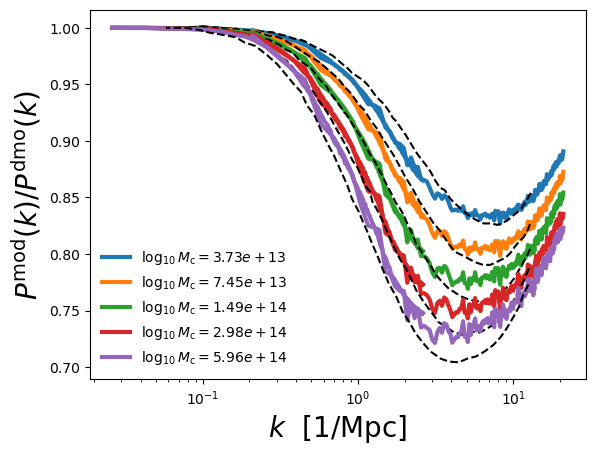

In [14]:
plt.xscale('log')

keys = [k for k in RES_M_c.keys() if not isinstance(k, str)]
for i in range(len(keys)):
    R = RES_M_c[keys[i]]
    for k in R.keys():
        plt.plot(R[k]['k'], R[k]['S'], color = f'C{i}', lw = 3, 
                 label = r'$\log_{10}M_{\rm c} = %0.2e$' % keys[i] if k == list(R.keys())[0] else None)
    
    #Some hacking to get the right key from dataframe
    k = str(int(keys[i] * h))
    k = f"Mc{'2p5' if k.replace('0','') == '25' else k.replace('0','')}e{np.max([k.count('0'), 13])}"
    
    plt.plot(S19[f'{k}_X'].values * h, S19[f'{k}_Y'].values, ls = '--', color = 'k')
    
plt.legend(frameon = False)
plt.ylabel(r'$P^{\rm mod}(k)/P^{\rm dmo}(k)$', size = 20)
plt.xlabel(r'$k$  [$\rm 1/Mpc$]', size = 20)

# Finally, do eta_star

Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


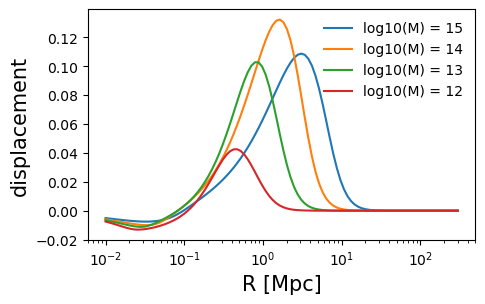

Baryonifying matter: 100%|██████████| 7088/7088 [01:41<00:00, 69.95it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.1
09:04:13
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.1
09:05:09


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


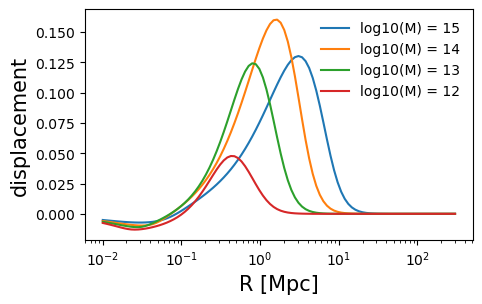

Baryonifying matter: 100%|██████████| 7088/7088 [01:42<00:00, 69.37it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.2
09:08:23
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.2
09:08:50


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


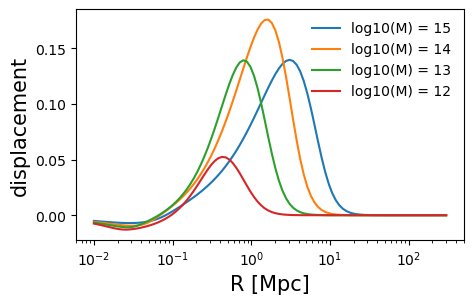

Baryonifying matter: 100%|██████████| 7088/7088 [01:42<00:00, 69.20it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.3
09:12:00
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.3
09:12:27


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


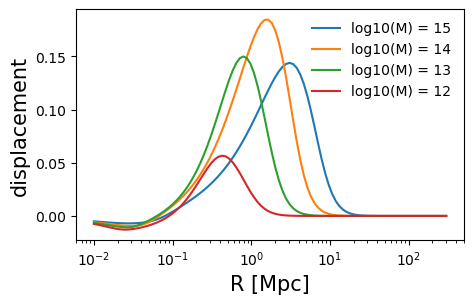

Baryonifying matter: 100%|██████████| 7088/7088 [01:42<00:00, 69.23it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.4
09:15:40
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.4
09:16:09


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


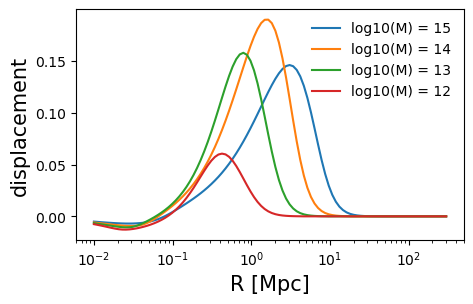

Baryonifying matter: 100%|██████████| 7088/7088 [01:43<00:00, 68.71it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 0.5
09:19:23
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 0.5
09:19:50


In [15]:
RES_eta = {'DM' : {}}

for param in [0.1, 0.2, 0.3, 0.4, 0.5]:
    
    RES_eta[param] = {}
    
    tmp = copy.deepcopy(bpar)
    tmp['eta'] = param
    tmp['eta_delta'] = 0.6 - param #Need to change this so eta_cga = 0.6 is held fixed
    DMO = bfn.DarkMatterOnly(**tmp)
    DMB = bfn.DarkMatterBaryon(**tmp, gas = Gas_S19(**tmp))

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfn.Profiles.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = 20)
    Displacement.setup_interpolator(z_min = 0, z_max = 0.01, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)
    
    #Plot to show
    R = np.geomspace(0.01, 300, 100)
    plt.figure(figsize = (5,3)); plt.xscale('log')
    for M in [1e15, 1e14, 1e13, 1e12]: plt.plot(R, Displacement.displacement(R, M, 1), label = 'log10(M) = %d' % np.log10(M))
    plt.ylabel('displacement', size = 15); plt.xlabel('R [Mpc]', size = 15); plt.legend(frameon = False)
    plt.show()
    
    #Swap in the new model into the Snapshot runner
    #And run the map!
    Runner.model    = Displacement
    Baryonified_Map = Runner.process()
    
    #Baryonified particle set
    Part_B = np.array([Baryonified_Map[x][:] for x in 'xyz']).T
    del Baryonified_Map; gc.collect()

    for factor in [1, 8]:

        Lbox = Snap.L / factor
        bins = np.linspace(0, Lbox, Ngrd + 1)
        
        MapB = numba_histogram3d(Part_B % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
        FFTB = np.fft.fftn(MapB); del MapB; gc.collect()
        FFTB = (np.conjugate(FFTB) * FFTB).real.flatten()
        PkB  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTB[kmsk]) / k_c; del FFTB; gc.collect()
        
        if f'Factor{factor}' not in RES_eta['DM'].keys():
            MapD = numba_histogram3d(Part_D % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
            FFTD = np.fft.fftn(MapD);  del MapD; gc.collect()
            FFTD = (np.conjugate(FFTD) * FFTD).real.flatten()
            PkD  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTD[kmsk]) / k_c; del FFTD; gc.collect()
            RES_eta['DM'][f'Factor{factor}'] = PkD
            
        else:
            PkD = RES_eta['DM'][f'Factor{factor}']

        
        RES_eta[param][f'Factor{factor}'] = {'k' : k_cen * factor, 'S' : PkB/PkD}
        
        print(f"FINISHED P(k) WITH FOLDING FACTOR {factor} FOR PARAM VALUE {param}")
        print(time.strftime("%H:%M:%S", time.localtime()))
        
    del Part_B; gc.collect()

Text(0.5, 0, '$k$  [$\\rm 1/Mpc$]')

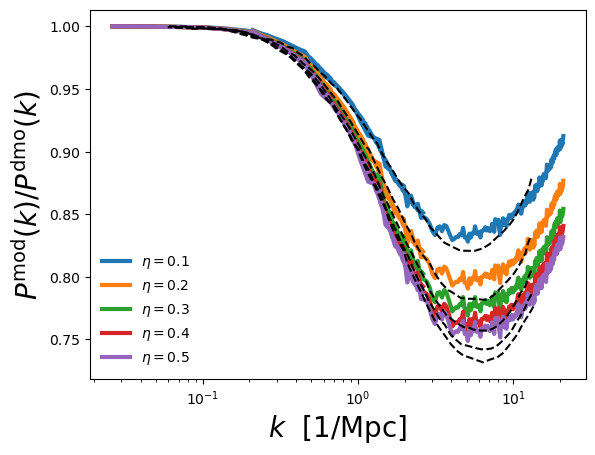

In [16]:
plt.xscale('log')

keys = [k for k in RES_eta.keys() if not isinstance(k, str)]
for i in range(len(keys)):
    R = RES_eta[keys[i]]
    for k in R.keys():
        plt.plot(R[k]['k'], R[k]['S'], color = f'C{i}', lw = 3, 
                 label = r'$\eta = %0.1f$' % keys[i] if k == list(R.keys())[0] else None)
    
    R = str(keys[i])[1:].replace('.', 'p')
    plt.plot(S19[f'E{R}_X'].values * h, S19[f'E{R}_Y'].values, ls = '--', color = 'k', zorder = 10000)
    
plt.legend(frameon = False)
plt.ylabel(r'$P^{\rm mod}(k)/P^{\rm dmo}(k)$', size = 20)
plt.xlabel(r'$k$  [$\rm 1/Mpc$]', size = 20)

# Now run for changes in theta_ej

Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


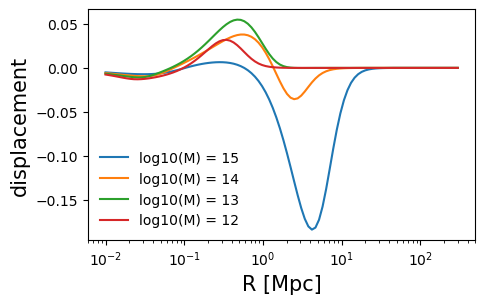

Baryonifying matter: 100%|██████████| 7088/7088 [01:41<00:00, 69.61it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 2
09:23:21
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 2
09:24:16


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


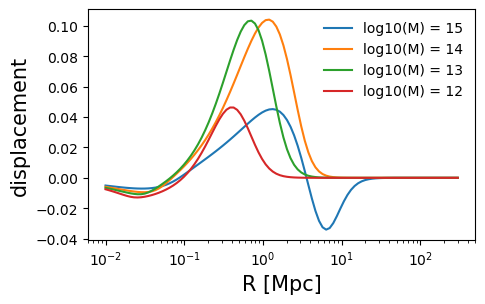

Baryonifying matter: 100%|██████████| 7088/7088 [01:43<00:00, 68.56it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 3
09:27:32
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 3
09:27:58


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


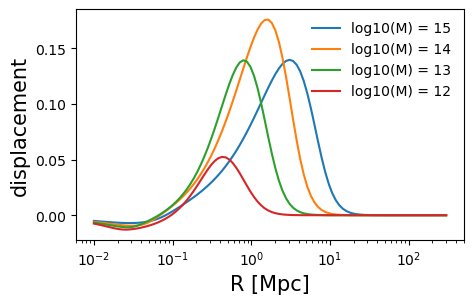

Baryonifying matter: 100%|██████████| 7088/7088 [01:43<00:00, 68.61it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 4
09:31:13
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 4
09:31:39


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


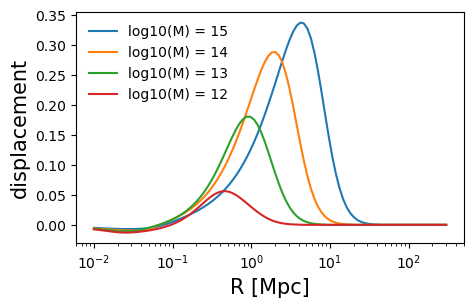

Baryonifying matter: 100%|██████████| 7088/7088 [01:42<00:00, 69.38it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 6
09:34:54
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 6
09:35:19


Building Table: 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


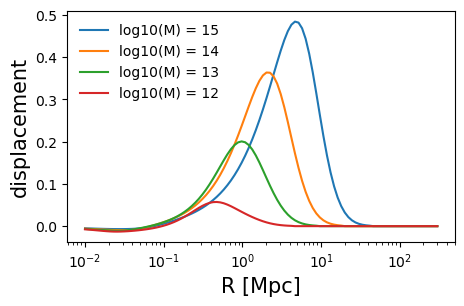

Baryonifying matter: 100%|██████████| 7088/7088 [01:42<00:00, 69.29it/s] 


FINISHED P(k) WITH FOLDING FACTOR 1 FOR PARAM VALUE 8
09:38:33
FINISHED P(k) WITH FOLDING FACTOR 8 FOR PARAM VALUE 8
09:38:59


In [17]:
RES_Tej = {'DM' : {}}

for param in [2, 3, 4, 6, 8]:
    
    RES_Tej[param] = {}
    
    tmp = copy.deepcopy(bpar)
    tmp['theta_ej'] = param
    DMO = bfn.DarkMatterOnly(**tmp)
    DMB = bfn.DarkMatterBaryon(**tmp, gas = Gas_S19(**tmp))

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfn.Profiles.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = 20)
    Displacement.setup_interpolator(z_min = 0, z_max = 0.01, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)
    
    #Plot to show
    R = np.geomspace(0.01, 300, 100)
    plt.figure(figsize = (5,3)); plt.xscale('log')
    for M in [1e15, 1e14, 1e13, 1e12]: plt.plot(R, Displacement.displacement(R, M, 1), label = 'log10(M) = %d' % np.log10(M))
    plt.ylabel('displacement', size = 15); plt.xlabel('R [Mpc]', size = 15); plt.legend(frameon = False)
    plt.show()
    
    #Swap in the new model into the Snapshot runner
    #And run the map!
    Runner.model    = Displacement
    Baryonified_Map = Runner.process()
    
    #Baryonified particle set
    Part_B = np.array([Baryonified_Map[x][:] for x in 'xyz']).T
    del Baryonified_Map; gc.collect()

    for factor in [1, 8]:

        Lbox = Snap.L / factor
        bins = np.linspace(0, Lbox, Ngrd + 1)
        
        MapB = numba_histogram3d(Part_B % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
        FFTB = np.fft.fftn(MapB); del MapB; gc.collect()
        FFTB = (np.conjugate(FFTB) * FFTB).real.flatten()
        PkB  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTB[kmsk]) / k_c; del FFTB; gc.collect()
        
        if f'Factor{factor}' not in RES_Tej['DM'].keys():
            MapD = numba_histogram3d(Part_D % Lbox, bins = Ngrd, min_vals = 0.0, max_vals = Lbox)
            FFTD = np.fft.fftn(MapD);  del MapD; gc.collect()
            FFTD = (np.conjugate(FFTD) * FFTD).real.flatten()
            PkD  = np.bincount(kinds[kmsk], minlength = Nk, weights = FFTD[kmsk]) / k_c; del FFTD; gc.collect()
            RES_Tej['DM'][f'Factor{factor}'] = PkD
            
        else:
            PkD = RES_Tej['DM'][f'Factor{factor}']

        
        RES_Tej[param][f'Factor{factor}'] = {'k' : k_cen * factor, 'S' : PkB/PkD}
        
        print(f"FINISHED P(k) WITH FOLDING FACTOR {factor} FOR PARAM VALUE {param}")
        print(time.strftime("%H:%M:%S", time.localtime()))
        
    
    del Part_B; gc.collect()

Text(0.5, 0, '$k$  [$\\rm 1/Mpc$]')

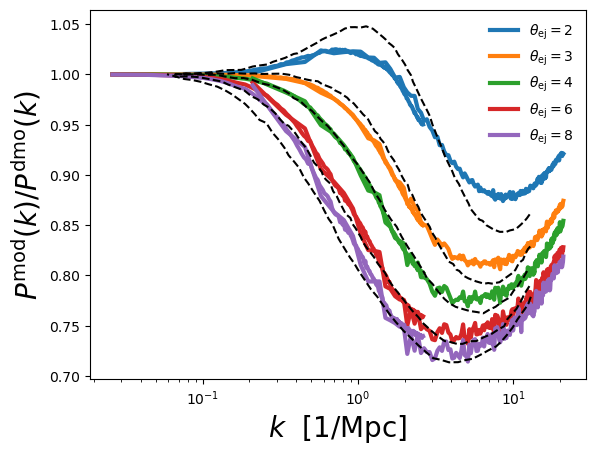

In [18]:
plt.xscale('log')

keys = [k for k in RES_Tej.keys() if not isinstance(k, str)]
for i in range(len(keys)):
    R = RES_Tej[keys[i]]
    for k in R.keys():
        plt.plot(R[k]['k'], R[k]['S'], color = f'C{i}', lw = 3, 
                 label = r'$\theta_{\rm ej} = %d$' % keys[i] if k == list(R.keys())[0] else None)
    
    plt.plot(S19[f'T{keys[i]}_X'].values * h, S19[f'T{keys[i]}_Y'].values, ls = '--', color = 'k', zorder = 10000)
    
plt.legend(frameon = False)
plt.ylabel(r'$P^{\rm mod}(k)/P^{\rm dmo}(k)$', size = 20)
plt.xlabel(r'$k$  [$\rm 1/Mpc$]', size = 20)